<table style="border: none" align="left">
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="5" color="black"><b>Predicting House Pricing with IBM Watson Machine Learning</b></th>
      <th style="border: none"><img src="https://github.com/pmservice/customer-satisfaction-prediction/blob/master/app/static/images/ml_icon_gray.png?raw=true" alt="Watson Machine Learning icon" height="40" width="40"></th>
  <tr style="border: none">
       <th style="border: none"><img src="https://storage.googleapis.com/kaggle-competitions/kaggle/5407/media/housesbanner.png" width="600" alt="Icon"> </th>
   </tr>
</table>

A house value is simply more than location and square footage. Like the features that make up a person, an educated party would want to know all aspects that give a house its value.We are going to take advantage of all of the feature variables available to use and use it to analyze and predict house prices.

USE CASE:

Client Housebuyer: This client wants to find their next dream home with a reasonable price tag. They have their locations of interest ready. Now, they want to know if the house price matches the house value. With this study, they can understand which features (ex. Number of bathrooms, location, etc.) influence the final price of the house. If all matches, they can ensure that they are getting a fair price.

Client Houseseller: Think of the average house-flipper. This client wants to take advantage of the features that influence a house price the most. They typically want to buy a house at a low price and invest on the features that will give the highest return. For example, buying a house at a good location but small square footage. The client will invest on making rooms at a small cost to get a large return.


##### The goal of this project is to use EDA, visualization, data cleaning, preprocessing, and ml models to predict home prices given the features of the home.



In [1]:
# from systemml import MLContext
# ml = MLContext(spark)
# ml.version()

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20190425144321-0002
KERNEL_ID = 00c8a512-1520-45bc-a79c-503187e33a7a


In [2]:
import warnings
warnings.filterwarnings('ignore')

!pip install https://github.com/IBM/coursera/blob/master/systemml-1.3.0-SNAPSHOT-python.tar.gz?raw=true


!ln -s -f ~/user-libs/python3/systemml/systemml-java/systemml-1.3.0-SNAPSHOT-extra.jar ~/user-libs/spark2/systemml-1.3.0-SNAPSHOT-extra.jar
!ln -s -f ~/user-libs/python3/systemml/systemml-java/systemml-1.3.0-SNAPSHOT.jar ~/user-libs/spark2/systemml-1.3.0-SNAPSHOT.jar

In [3]:
!pip install wget

pyspark 2.3.0 requires py4j==0.10.6, which is not installed.
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
Target directory /home/spark/shared/user-libs/python3/__pycache__ already exists. Specify --upgrade to force replacement.
Target directory /home/spark/shared/user-libs/python3/wget-3.2.dist-info already exists. Specify --upgrade to force replacement.
Target directory /home/spark/shared/user-libs/python3/wget.py already exists. Specify --upgrade to force replacement.


In [4]:
import wget

link_to_data = 'https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv'
filename = wget.download(link_to_data)

print(filename)

BostonHousing (2).csv


In [5]:
spark = SparkSession.builder.getOrCreate()

df_data = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .option('inferSchema', 'true')\
  .load(filename)


### For each house observation, we have the following information:

<ol><li>CRIM — per capita crime rate by town.</li>

<li>ZN — proportion of residential land zoned for lots over 25,000 sq.ft.</li>

<li>INDUS — proportion of non-retail business acres per town.</li>

<li>CHAS — Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)</li>

<li>NOX — nitrogen oxides concentration (parts per 10 million).</li>

<li>RM — average number of rooms per dwelling.</li>

<li>AGE — proportion of owner-occupied units built prior to 1940.</li>

<li>DIS — weighted mean of distances to five Boston employment centres.</li>

<li>RAD — index of accessibility to radial highways.</li>

<li>TAX — full-value property-tax rate per 10000 dollars.</li>

<li>PTRATIO — pupil-teacher ratio by town.</li>

<li>BLACK — 1000(Bk — 0.63)² where Bk is the proportion of blacks by town.</li>

<li>LSTAT — lower status of the population (percent).</li>

<li>MV — median value of owner-occupied homes in 1000s. This is the target variable.</li></ol>

Explore the loaded data by using the following Apache® Spark DataFrame methods:
-  print schema
-  count all records
-  show distribution of label classes

In [6]:
df_data.printSchema()
print('Number of fields:',len(df_data.schema))

root
 |-- crim: double (nullable = true)
 |-- zn: double (nullable = true)
 |-- indus: double (nullable = true)
 |-- chas: integer (nullable = true)
 |-- nox: double (nullable = true)
 |-- rm: double (nullable = true)
 |-- age: double (nullable = true)
 |-- dis: double (nullable = true)
 |-- rad: integer (nullable = true)
 |-- tax: integer (nullable = true)
 |-- ptratio: double (nullable = true)
 |-- b: double (nullable = true)
 |-- lstat: double (nullable = true)
 |-- medv: double (nullable = true)

Number of fields: 14


As you can see, the data contains 14 fields. "medv" field is the one we would like to predict (label).

In [7]:
print("Total number of records: " + str(df_data.count()))

Total number of records: 506


Now you will check if all records have complete data.

In [8]:
df_complete = df_data.dropna()
print("Number of records with complete data: %3g" % df_complete.count())

Number of records with complete data: 506


## Top 10 rows

In [9]:
df_data.show(10)

+-------+----+-----+----+-----+-----+-----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm|  age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+----+-----+----+-----+-----+-----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575| 65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421| 78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185| 61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998| 45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147| 54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|
|0.02985| 0.0| 2.18|   0|0.458| 6.43| 58.7|6.0622|  3|222|   18.7|394.12| 5.21|28.7|
|0.08829|12.5| 7.87|   0|0.524|6.012| 66.6|5.5605|  5|311|   15.2| 395.6|12.43|22.9|
|0.14455|12.5| 7.87|   0|0.524|6.172| 96.1|5.9505|  5|311|   15.2| 396.9|19.15|27.1|
|0.21124|12.5| 7.87|   0|0.524|5.631|100.0|6.0821|  5|311|   15.2

## Statistical Summary

In [10]:
df_data.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
crim,506,3.6135235573122535,8.601545105332491,0.00632,88.9762
zn,506,11.363636363636363,23.32245299451514,0.0,100.0
indus,506,11.136778656126504,6.860352940897589,0.46,27.74
chas,506,0.0691699604743083,0.2539940413404101,0,1
nox,506,0.5546950592885372,0.11587767566755584,0.385,0.871
rm,506,6.284634387351787,0.7026171434153232,3.561,8.78
age,506,68.57490118577078,28.148861406903595,2.9,100.0
dis,506,3.795042687747034,2.10571012662761,1.1296,12.1265
rad,506,9.549407114624506,8.707259384239366,1,24


## Data Exploration


Calculate Statistics


In [11]:
df_data.createOrReplaceTempView("df_data")

In [12]:
# Minimum price of the data
minimum_price = spark.sql('select min(medv) from df_data ').collect()[0][0]

# Maximum price of the data
maximum_price = spark.sql('select max(medv) from df_data ').collect()[0][0]


# Mean price of the data
mean_price = spark.sql('select mean(medv) from df_data ').collect()[0][0]


# Standard deviation of prices of the data
std_price = spark.sql('select std(medv) from df_data ').collect()[0][0]


# Show the calculated statistics
print("Statistics for Boston housing dataset:\n")
print("Minimum price: ${}".format(minimum_price)) 
print("Maximum price: ${}".format(maximum_price))
print("Mean price: ${}".format(mean_price))
print("Standard deviation of prices: ${}".format(std_price))

Statistics for Boston housing dataset:

Minimum price: $5.0
Maximum price: $50.0
Mean price: $22.532806324110698
Standard deviation of prices: $9.197104087379815


## Data Preprocessing / feature reduction 

In [13]:
from pyspark.mllib.stat import Statistics
import pandas as pd
import six
for i in df_data.columns:
    if not (isinstance(df_data.select(i).take(1)[0][0],six.string_types)):
        print('Correlation of medv for', i,' ', df_data.stat.corr('medv',i))
    

Correlation of medv for crim   -0.38830460858681154
Correlation of medv for zn   0.3604453424505433
Correlation of medv for indus   -0.4837251600283728
Correlation of medv for chas   0.1752601771902987
Correlation of medv for nox   -0.4273207723732821
Correlation of medv for rm   0.6953599470715401
Correlation of medv for age   -0.3769545650045961
Correlation of medv for dis   0.249928734085904
Correlation of medv for rad   -0.38162623063977735
Correlation of medv for tax   -0.46853593356776674
Correlation of medv for ptratio   -0.5077866855375622
Correlation of medv for b   0.3334608196570661
Correlation of medv for lstat   -0.7376627261740145
Correlation of medv for medv   1.0


#### The essential features are: ‘RM’, ‘LSTAT’, ‘PTRATIO’ and ‘MEDV’. The remaining features have been excluded.

In [14]:
def compute_correlation_matrix(df, method='pearson'):
    df_rdd = df.rdd.map(lambda row: row[:])
    corr_mat = Statistics.corr(df_rdd, method=method)
    corr_mat_df = pd.DataFrame(corr_mat,
                    columns=df.columns, 
                    index=df.columns)
    return corr_mat_df

In [15]:
import numpy as np
corr = np.abs(compute_correlation_matrix(df_data))
pd.DataFrame(corr['medv'][corr['medv']>0.5]).rename(columns={'medv':'importance'})

,importance
rm,0.695360
ptratio,0.507787
lstat,0.737663
medv,1.000000


In [16]:
dataset = df_data.select(['rm','ptratio','lstat','medv'])

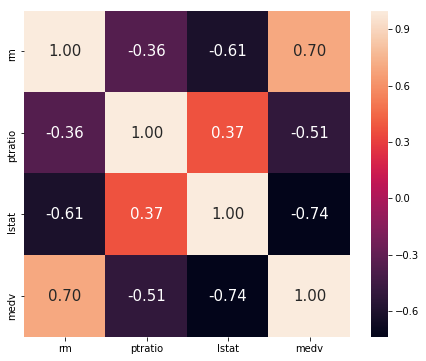

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
corr = compute_correlation_matrix(dataset)
plt.figure(figsize=(7.5,6))
sns.heatmap(corr,cbar=True,
                annot=True,
                square=True,
                fmt='.2f',
                annot_kws={'size': 15},
                yticklabels=corr.columns,
                xticklabels=corr.columns)

## Exploratory Data Analysis 

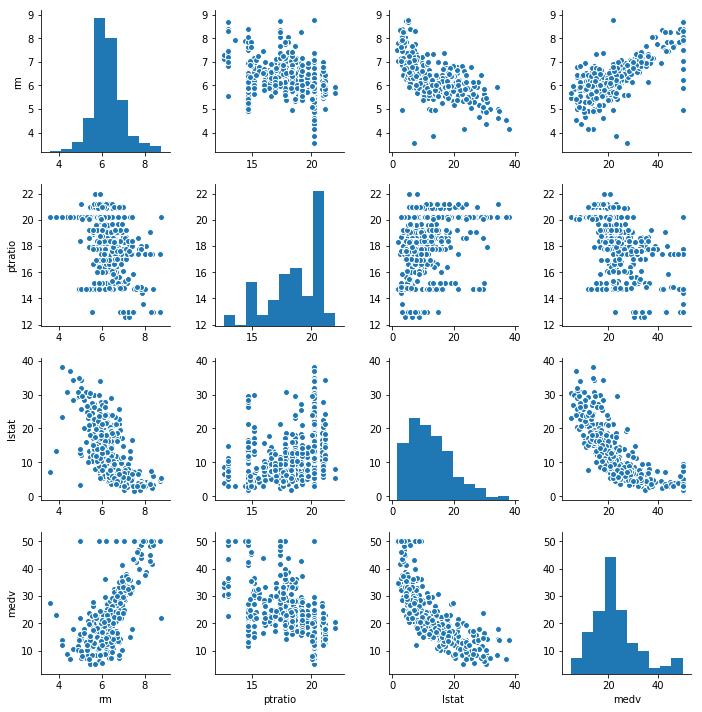

In [18]:
sns.pairplot(dataset.toPandas())

<a id="model"></a>
## Create an Apache® Spark machine learning model

create an Apache® Spark machine learning pipeline, and train a model.

#### Prepare data
train, test and predict datasets.

In [19]:
traindf , testdf = dataset.randomSplit([0.7,0.3])

In [20]:
traindf.columns

['rm', 'ptratio', 'lstat', 'medv']

In [21]:
from pyspark.ml.feature import VectorAssembler

In [22]:
vectorAssembler = VectorAssembler(inputCols = ['rm', 'ptratio', 'lstat'],outputCol='features')


## Model definition

In [23]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol='features',labelCol='medv',regParam=0.3,maxIter=10,elasticNetParam=0.8)

In [24]:
from pyspark.ml import Pipeline, Model

## Model building

In [25]:
pipeline_lr = Pipeline(stages=[vectorAssembler,lr])
model_lr = pipeline_lr.fit(traindf)

You can check **model accuracy** now. To evaluate the model, use **test data**.

In [26]:
print("Coefficients: " + str(model_lr.stages[-1].coefficients))
print("Intercept: " + str(model_lr.stages[-1].intercept))
print("R2 score: ", model_lr.stages[-1].summary.r2)
print("RMSE: ", model_lr.stages[-1].summary.rootMeanSquaredError)

Coefficients: [4.44569350484,-0.889930190331,-0.560103012947]
Intercept: 18.031697187623866
R2 score:  0.6824656101798123
RMSE:  5.194868168116642


In [27]:
traindf.select('medv').describe().show()

+-------+------------------+
|summary|              medv|
+-------+------------------+
|  count|               352|
|   mean|22.414772727272723|
| stddev| 9.232023910024578|
|    min|               5.0|
|    max|              50.0|
+-------+------------------+



R squared at 0.68 indicates that in our model, approximate 68% of the variability in “MEDV” 

In [28]:
from pyspark.ml.evaluation import RegressionEvaluator
predictions = model_lr.transform(testdf)
evaluator = RegressionEvaluator(labelCol="medv", predictionCol="prediction", metricName="r2")
evaluatorRmse = RegressionEvaluator(labelCol="medv", predictionCol="prediction", metricName="rmse")

r2 = evaluator.evaluate(predictions)
rmse = evaluatorRmse.evaluate(predictions)


print("Test dataset:")
print("R2 = %.2f" % r2)
print("RMSE = %.2f" % rmse)

Test dataset:
R2 = 0.67
RMSE = 5.25


Using our Linear Regression model to make some predictions

In [29]:
test_result = model_lr.transform(testdf)
test_result.show()

+-----+-------+-----+----+------------------+------------------+
|   rm|ptratio|lstat|medv|          features|        prediction|
+-----+-------+-----+----+------------------+------------------+
|3.561|   20.2| 7.12|27.5| [3.561,20.2,7.12]|11.898288461492294|
|3.863|   20.2|13.33|23.1|[3.863,20.2,13.33]|  9.76264818955324|
|4.138|   20.2|23.34|11.9|[4.138,20.2,23.34]|5.3785827437850156|
|4.628|   20.2|34.37|17.9|[4.628,20.2,34.37]|1.3790363283514573|
|4.906|   20.2|34.77|13.8|[4.906,20.2,34.77]|2.3908979175181457|
|4.926|   14.7|29.53|14.6|[4.926,14.7,29.53]|10.309367622276955|
|  5.0|   20.2|31.99| 7.4|  [5.0,20.2,31.99]| 4.365879482965681|
|5.093|   20.1|29.68| 8.1|[5.093,20.1,29.68]| 6.162159957856382|
|5.349|   20.2|19.77| 8.3|[5.349,20.2,19.77]|12.761885334366792|
|5.362|   20.2|10.19|20.8|[5.362,20.2,10.19]|  18.1854662139617|
| 5.39|   19.2|21.14|19.7| [5.39,19.2,21.14]|13.066747830658759|
| 5.39|   20.2|20.85|11.5| [5.39,20.2,20.85]|12.339247514082494|
|5.399|   17.9|30.81|14.4

### Decision tree regression


In [30]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'medv')
pipeline_dt = Pipeline(stages=[vectorAssembler,dt])
model_dt = pipeline_dt.fit(traindf)


In [31]:
model_dt.stages[-1].featureImportances

SparseVector(3, {0: 0.5733, 1: 0.1157, 2: 0.311})

In [32]:
dataset.take(1)

[Row(rm=6.575, ptratio=15.3, lstat=4.98, medv=24.0)]

## Model building

In [33]:
predictions = model_dt.transform(testdf)
evaluatorRmse = RegressionEvaluator(labelCol="medv", predictionCol="prediction", metricName="mse")

r2 = evaluator.evaluate(predictions)
mse = evaluatorRmse.evaluate(predictions)


print("Test dataset:")
print("R2 = %.2f" % r2)
print("MSE = %.2f" % mse)

Test dataset:
R2 = 0.72
MSE = 23.03


In [34]:
predictions.show(10)

+-----+-------+-----+----+------------------+------------------+
|   rm|ptratio|lstat|medv|          features|        prediction|
+-----+-------+-----+----+------------------+------------------+
|3.561|   20.2| 7.12|27.5| [3.561,20.2,7.12]|23.446153846153848|
|3.863|   20.2|13.33|23.1|[3.863,20.2,13.33]|  20.4811320754717|
|4.138|   20.2|23.34|11.9|[4.138,20.2,23.34]|12.192857142857145|
|4.628|   20.2|34.37|17.9|[4.628,20.2,34.37]|  9.05294117647059|
|4.906|   20.2|34.77|13.8|[4.906,20.2,34.77]|  9.05294117647059|
|4.926|   14.7|29.53|14.6|[4.926,14.7,29.53]|            15.275|
|  5.0|   20.2|31.99| 7.4|  [5.0,20.2,31.99]|  9.05294117647059|
|5.093|   20.1|29.68| 8.1|[5.093,20.1,29.68]|  9.05294117647059|
|5.349|   20.2|19.77| 8.3|[5.349,20.2,19.77]|            15.952|
|5.362|   20.2|10.19|20.8|[5.362,20.2,10.19]|  20.4811320754717|
+-----+-------+-----+----+------------------+------------------+
only showing top 10 rows



### Gradient-boosted tree regression


In [35]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder
from pyspark.ml.feature import Normalizer

## Model definition

In [37]:
normalizer = Normalizer(inputCol='features',outputCol='features_norm',p=15.0,)
gbt = GBTRegressor(featuresCol ='features_norm', labelCol = 'medv',maxIter=5,seed=543)
Pipeline_gbt = Pipeline(stages=[vectorAssembler,normalizer,gbt])
model_gbt = Pipeline_gbt.fit(traindf)

## Model building

In [38]:
predictions = model_gbt.transform(testdf)
evaluatorRmse = RegressionEvaluator(labelCol="medv", predictionCol="prediction", metricName="mse")
evaluatorR2 = RegressionEvaluator(labelCol="medv", predictionCol="prediction", metricName="r2")

mse = evaluatorRmse.evaluate(predictions)
r2 = evaluatorR2.evaluate(predictions)


print("Test dataset:")
print("r2 = %.2f" % r2)
print("MSE = %.2f" % mse)


Test dataset:
r2 = 0.71
MSE = 23.67


In [39]:
predictions.show(10)

+-----+-------+-----+----+------------------+--------------------+------------------+
|   rm|ptratio|lstat|medv|          features|       features_norm|        prediction|
+-----+-------+-----+----+------------------+--------------------+------------------+
|3.561|   20.2| 7.12|27.5| [3.561,20.2,7.12]|[0.17628712682021...|19.614236849520545|
|3.863|   20.2|13.33|23.1|[3.863,20.2,13.33]|[0.19121266573520...| 19.05246073515689|
|4.138|   20.2|23.34|11.9|[4.138,20.2,23.34]|[0.17601565249933...|  8.55751057792705|
|4.628|   20.2|34.37|17.9|[4.628,20.2,34.37]|[0.13464921835153...|11.887381284997758|
|4.906|   20.2|34.77|13.8|[4.906,20.2,34.77]|[0.14109592201649...|11.887381284997758|
|4.926|   14.7|29.53|14.6|[4.926,14.7,29.53]|[0.16681309244686...|11.887381284997758|
|  5.0|   20.2|31.99| 7.4|  [5.0,20.2,31.99]|[0.15628830711083...|11.887381284997758|
|5.093|   20.1|29.68| 8.1|[5.093,20.1,29.68]|[0.17156401844972...|  8.55751057792705|
|5.349|   20.2|19.77| 8.3|[5.349,20.2,19.77]|[0.255358

### Deep learning model

In [75]:
import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import KFold, GridSearchCV,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [41]:
dataset_nn = df_data.toPandas()

In [42]:
X = dataset_nn['crim zn indus chas nox rm age dis rad tax ptratio b lstat'.split()]
Y = dataset_nn['medv']

## Defining a base line model

In [43]:
def baseline():
    model = Sequential()
    model.add(Dense(13,input_dim=13,activation='relu',kernel_initializer='normal'))
    model.add(Dense(1, kernel_initializer='normal'))    #compile
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model

In [44]:
seed=7
np.random.seed(seed)
estimator = KerasRegressor(build_fn=baseline,epochs=100,verbose=0,batch_size=5)

In [45]:
kfold = KFold(n_splits=5, random_state=seed)
results = cross_val_score(estimator, X, Y, cv=kfold)
print("Results: Mean %.2f (%.2f) MSE" % (results.mean(), results.std()))


Results: Mean -38.78 (19.70) MSE


### Modeling The Standardized Dataset


In [46]:
numpy.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(pipeline, X, Y, cv=kfold)
print("Standardized: Mean %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [47]:
print("Standardized: Mean %.2f (%.2f) MSE" % (results.mean(), results.std()))

Standardized: Mean -29.26 (27.77) MSE


### Tune The Neural Network Topology

In [48]:
def larger_model():
    # create model
    model = Sequential()
    model.add(Dense(23, input_dim=13, kernel_initializer='normal', activation='relu'))
    model.add(Dense(16, kernel_initializer='normal', activation='relu'))
    model.add(Dense(6, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mse',metrics=['mse', 'mae', 'mape'], optimizer='adam')
    return model

In [76]:
optimizers = ['adam']
init = ['normal']
epochs = [50,100]
batches = [4,6,9]
mlp = KerasRegressor(build_fn=larger_model, verbose=0)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', mlp))
estimators

[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('mlp', <keras.wrappers.scikit_learn.KerasRegressor at 0x2b00d8c6ac18>)]

In [78]:
pipeline = Pipeline(estimators)
scalers_to_test = [StandardScaler(), RobustScaler(), MinMaxScaler()]

param_grid = {'mlp__epochs':epochs, 'mlp__batch_size':batches}

gcv = GridSearchCV(pipeline,param_grid,verbose=2)
gcv.fit(X, Y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] mlp__batch_size=4, mlp__epochs=50 ...............................
[CV] ................ mlp__batch_size=4, mlp__epochs=50, total=   9.0s
[CV] mlp__batch_size=4, mlp__epochs=50 ...............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.1s remaining:    0.0s


[CV] ................ mlp__batch_size=4, mlp__epochs=50, total=   8.5s
[CV] mlp__batch_size=4, mlp__epochs=50 ...............................
[CV] ................ mlp__batch_size=4, mlp__epochs=50, total=   8.5s
[CV] mlp__batch_size=4, mlp__epochs=100 ..............................
[CV] ............... mlp__batch_size=4, mlp__epochs=100, total=  15.9s
[CV] mlp__batch_size=4, mlp__epochs=100 ..............................
[CV] ............... mlp__batch_size=4, mlp__epochs=100, total=  15.7s
[CV] mlp__batch_size=4, mlp__epochs=100 ..............................
[CV] ............... mlp__batch_size=4, mlp__epochs=100, total=  15.8s
[CV] mlp__batch_size=6, mlp__epochs=50 ...............................
[CV] ................ mlp__batch_size=6, mlp__epochs=50, total=   6.4s
[CV] mlp__batch_size=6, mlp__epochs=50 ...............................
[CV] ................ mlp__batch_size=6, mlp__epochs=50, total=   6.7s
[CV] mlp__batch_size=6, mlp__epochs=50 ...............................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  2.9min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('mlp', <keras.wrappers.scikit_learn.KerasRegressor object at 0x2b00d8c6ac18>)]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'mlp__batch_size': [4, 6, 9], 'mlp__epochs': [50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [71]:
gcv.best_params_

{'mlp__batch_size': 6, 'mlp__epochs': 50}

In [52]:
scalar = StandardScaler()
x_scalar = scalar.fit(X)
y_scalar = scalar.fit(np.reshape(Y,(-1,1)))


In [53]:
x_set = x_scalar.transform(np.array(X))
y_set = y_scalar.transform(np.reshape(np.array(Y),(-1,1)))
history = mlp.fit(x_set,y_set,validation_split=0.33,epochs=gcv.best_params_['mlp__epochs'], 
                  batch_size=gcv.best_params_['mlp__batch_size'],verbose = 2)
print(history.history.keys())

Train on 339 samples, validate on 167 samples
Epoch 1/50
 - 1s - loss: 0.9308 - mean_squared_error: 0.9308 - mean_absolute_error: 0.6648 - mean_absolute_percentage_error: 130.4485 - val_loss: 1.2594 - val_mean_squared_error: 1.2594 - val_mean_absolute_error: 0.9298 - val_mean_absolute_percentage_error: 133.5559
Epoch 2/50
 - 0s - loss: 0.8752 - mean_squared_error: 0.8752 - mean_absolute_error: 0.6807 - mean_absolute_percentage_error: 225.2357 - val_loss: 1.3479 - val_mean_squared_error: 1.3479 - val_mean_absolute_error: 0.9854 - val_mean_absolute_percentage_error: 171.9052
Epoch 3/50
 - 0s - loss: 0.8253 - mean_squared_error: 0.8253 - mean_absolute_error: 0.6753 - mean_absolute_percentage_error: 271.8440 - val_loss: 1.2114 - val_mean_squared_error: 1.2114 - val_mean_absolute_error: 0.9254 - val_mean_absolute_percentage_error: 160.3540
Epoch 4/50
 - 0s - loss: 0.7604 - mean_squared_error: 0.7604 - mean_absolute_error: 0.6415 - mean_absolute_percentage_error: 301.7802 - val_loss: 0.9381 

Epoch 32/50
 - 0s - loss: 0.2568 - mean_squared_error: 0.2568 - mean_absolute_error: 0.3714 - mean_absolute_percentage_error: 315.4016 - val_loss: 0.4944 - val_mean_squared_error: 0.4944 - val_mean_absolute_error: 0.4719 - val_mean_absolute_percentage_error: 220.3075
Epoch 33/50
 - 0s - loss: 0.2568 - mean_squared_error: 0.2568 - mean_absolute_error: 0.3736 - mean_absolute_percentage_error: 369.1409 - val_loss: 0.4479 - val_mean_squared_error: 0.4479 - val_mean_absolute_error: 0.4569 - val_mean_absolute_percentage_error: 188.6361
Epoch 34/50
 - 0s - loss: 0.2261 - mean_squared_error: 0.2261 - mean_absolute_error: 0.3586 - mean_absolute_percentage_error: 395.5318 - val_loss: 0.4940 - val_mean_squared_error: 0.4940 - val_mean_absolute_error: 0.4681 - val_mean_absolute_percentage_error: 219.5141
Epoch 35/50
 - 0s - loss: 0.2237 - mean_squared_error: 0.2237 - mean_absolute_error: 0.3546 - mean_absolute_percentage_error: 365.5408 - val_loss: 0.4104 - val_mean_squared_error: 0.4104 - val_mea

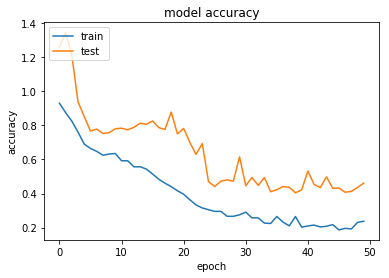

In [54]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('mean_absolute_error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

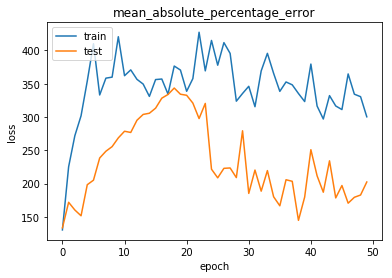

In [59]:
plt.plot(history.history['mean_absolute_percentage_error'])
plt.plot(history.history['val_mean_absolute_percentage_error'])
plt.title('mean_absolute_percentage_error')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

The mean absolute percentage error (MAPE), also known as mean absolute percentage deviation (MAPD), is a measure of prediction accuracy 

Thank you :)